# Prepare

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *

2022-05-17 20:22:43.133656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Load

In [2]:
## 경로 설정
small_train_images_path = './data/PREPROCESSING-TRAIN'
small_test_images_path = './data/PREPROCESSING-TEST'
data_path = './data'

train_images_name = sorted(os.listdir(small_train_images_path))
train_images_path = \
[os.path.join(small_train_images_path, name) for name in train_images_name]

test_images_name = sorted(os.listdir(small_test_images_path))
test_images_path = \
[os.path.join(small_test_images_path, name) for name in test_images_name]

label_dfs = []
case_names = sorted(os.listdir('./data/train'))

for case in case_names :
    label_path = data_path+'/train/'+case+'/label-{}.csv'.format(str(int(case[-2:])))
    df = pd.read_csv(label_path)
    label_dfs.append(df)
    
label_df = pd.concat(label_dfs, axis=0)
label_df.to_csv('./data/labels.csv', index=False)

label_df.set_index('img_name', inplace=True)

label_df['img_path'] = train_images_path

shuffled_df = label_df.sample(frac=1)

# Data Generator

In [3]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(shuffled_df)*0.8)

train_df = shuffled_df[:train_len]
valid_df = shuffled_df[train_len:]

train_img_path = train_df['img_path'].to_list()
train_label = train_df['leaf_weight'].to_list()

valid_img_path = valid_df['img_path'].to_list()
valid_label = valid_df['leaf_weight'].to_list()

In [4]:
%%time
train_img = np.array(list(map(cv2.imread, train_img_path)))
valid_img = np.array(list(map(cv2.imread, valid_img_path)))

CPU times: user 8.71 s, sys: 966 ms, total: 9.68 s
Wall time: 11.3 s


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
BATCH_SIZE = 19

train_generator = train_datagen.flow(train_img,
                                    train_label,
                                    batch_size=BATCH_SIZE)

valid_generator = test_datagen.flow(valid_img,
                                    valid_label,
                                   batch_size=BATCH_SIZE)

In [13]:
PRED_BATCH_SIZE = 10
test_img = np.array(list(map(cv2.imread, test_images_path)))
test_generator = test_datagen.flow(test_img,
                                   shuffle=False,
                                   batch_size=PRED_BATCH_SIZE)

In [7]:
IMAGE_SIZE = 512
MODEL_IMAGE_SIZE = 299

# Definitions

In [8]:
def NMAE(y_true, y_pred) :
    error = y_true - y_pred
    absolute_error = tf.abs(error)
    return tf.reduce_mean(absolute_error) / tf.reduce_mean(y_true)

def nmae(y_true, y_pred):
    score = tf.py_function(func=NMAE, inp=[y_true, y_pred], Tout=tf.float32, name='nmae')
    return score

<h1> inception_v2_resnet 0.001 adam 0.2 </h1>
<img src='./Training_Result/inception_v2_resnet 0.001 adam 0.2.png'/>

In [9]:
tf.keras.backend.clear_session()

base_model = inception_resnet_v2.InceptionResNetV2(
            weights='imagenet',
            include_top = False,
            input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3))

input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
output_data = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=output_data, name='resize')

# model
inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='relu')(x)
model = Model(inputs, outputs)

base_model.trainable = False
model.summary()

2022-05-17 20:23:40.580787: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-17 20:23:40.582110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-17 20:23:40.627299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 20:23:40.627898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-17 20:23:40.627927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-17 20:23:40.704679: I tensorflow/stream_executor/platform/default/dso_loade

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resize (Functional)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025  

In [10]:
model.compile(optimizer=Adam(0.001),
            loss='mae',
            metrics=[nmae])

ckpt_path = './Best_Check_Point/final_best_params_top_layers.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_nmae',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
VAL_STEPS = len(valid_img) // BATCH_SIZE

history = model.fit(train_generator, epochs=30,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  validation_data=valid_generator,
                  validation_steps = VAL_STEPS,
                  callbacks=[checkpointer],
                  verbose=1)

model.save('./final_best_top_layer.h5')

2022-05-17 20:24:53.132170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-17 20:24:53.149650: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/30


2022-05-17 20:25:00.862279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-17 20:25:01.822498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


67/67 [==============================] - 79s 1s/step - loss: 55.1044 - nmae: 0.7103 - val_loss: 20.1758 - val_nmae: 0.2571

Epoch 00001: val_nmae improved from inf to 0.25707, saving model to ./Best_Check_Point/final_best_params_top_layers.ckpt
Epoch 2/30
67/67 [==============================] - 66s 982ms/step - loss: 17.5995 - nmae: 0.2245 - val_loss: 17.4158 - val_nmae: 0.2295

Epoch 00002: val_nmae improved from 0.25707 to 0.22951, saving model to ./Best_Check_Point/final_best_params_top_layers.ckpt
Epoch 3/30
67/67 [==============================] - 66s 979ms/step - loss: 16.4616 - nmae: 0.2209 - val_loss: 19.1424 - val_nmae: 0.2323

Epoch 00003: val_nmae did not improve from 0.22951
Epoch 4/30
67/67 [==============================] - 66s 982ms/step - loss: 15.6200 - nmae: 0.2005 - val_loss: 14.9332 - val_nmae: 0.1953

Epoch 00004: val_nmae improved from 0.22951 to 0.19532, saving model to ./Best_Check_Point/final_best_params_top_layers.ckpt
Epoch 5/30
67/67 [======================

In [11]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
train_nmae = history.history['nmae']
valid_nmae = history.history['val_nmae']

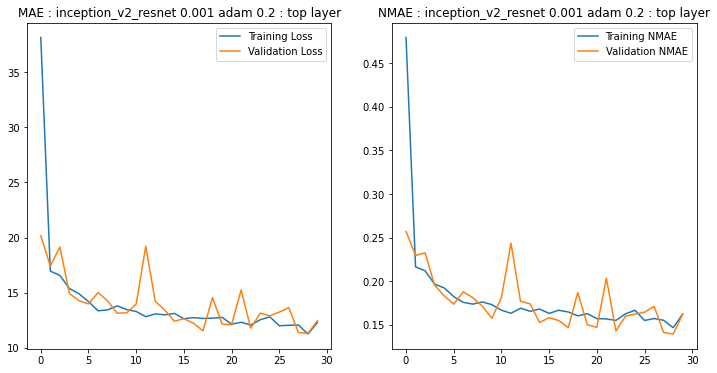

In [12]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
ax1.set_title('MAE : inception_v2_resnet 0.001 adam 0.2 : top layer')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
ax2.set_title('NMAE : inception_v2_resnet 0.001 adam 0.2 : top layer')

plt.show()

In [14]:
model.load_weights('./Best_Check_Point/final_best_params_top_layers.ckpt')

prediction = model.predict(test_generator,
                          steps=len(test_images_path)/PRED_BATCH_SIZE,
                          batch_size = PRED_BATCH_SIZE) 

submission = pd.read_csv('./data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./data/inception v2 resnet 1e-3 adam 0.2.csv', index=False)

### finetune

In [57]:
model.load_weights('./Best_Check_Point/final_best_params_top_layers.ckpt')

In [58]:
freeze_rate = 0
base_model.trainable=True
fine_tune_at = int(len(base_model.layers) * freeze_rate)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = False    

model.compile(optimizer=Adam(0.0001),
        loss='mae',
        metrics=[nmae])

es = EarlyStopping(monitor='loss',
                mode='auto',
                patience=5,
                verbose=1)

ckpt_path = './Best_Check_Point/final_best_params_finetune_{}.ckpt'.format(freeze_rate)
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_nmae',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
VAL_STEPS = len(valid_img) // BATCH_SIZE

history_fine = model.fit(train_generator, epochs=60,
                         initial_epoch = 30,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_generator,
                          validation_steps = VAL_STEPS,
                          callbacks=[checkpointer, es],
                          verbose=1)

model.save('./Model_Save/final_best_params_finetune_{}.h5'.format(freeze_rate))
model.load_weights(ckpt_path)
model.save('./Model_Save/final_best_params_finetune_{}_2.h5'.format(freeze_rate))

Epoch 31/60
67/67 [==============================] - 84s 1s/step - loss: 39.6810 - nmae: 0.5630 - val_loss: 10.4179 - val_nmae: 0.1282

Epoch 00031: val_nmae improved from inf to 0.12816, saving model to ./Best_Check_Point/final_best_params_finetune_0.ckpt
Epoch 32/60
67/67 [==============================] - 68s 1000ms/step - loss: 12.5657 - nmae: 0.1603 - val_loss: 10.7093 - val_nmae: 0.1356

Epoch 00032: val_nmae did not improve from 0.12816
Epoch 33/60
67/67 [==============================] - 68s 1s/step - loss: 10.3820 - nmae: 0.1357 - val_loss: 13.7682 - val_nmae: 0.1791

Epoch 00033: val_nmae did not improve from 0.12816
Epoch 34/60
67/67 [==============================] - 68s 1s/step - loss: 11.4900 - nmae: 0.1468 - val_loss: 8.6992 - val_nmae: 0.1060

Epoch 00034: val_nmae improved from 0.12816 to 0.10600, saving model to ./Best_Check_Point/final_best_params_finetune_0.ckpt
Epoch 35/60
67/67 [==============================] - 67s 991ms/step - loss: 9.6520 - nmae: 0.1234 - val_l

In [59]:
train_loss = train_loss[:30]
valid_loss = valid_loss[:30]
train_nmae = train_nmae[:30]
valid_nmae = valid_nmae[:30]

In [60]:
train_loss += history_fine.history['loss']
valid_loss += history_fine.history['val_loss']
train_nmae += history_fine.history['nmae']
valid_nmae += history_fine.history['val_nmae']

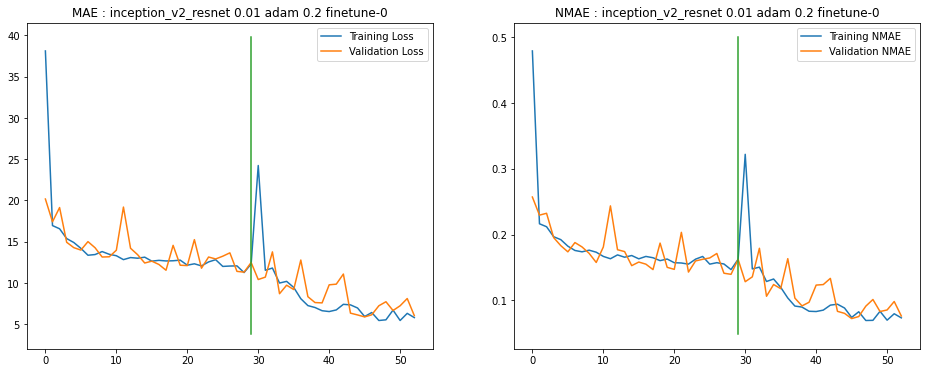

In [61]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

plt.show()

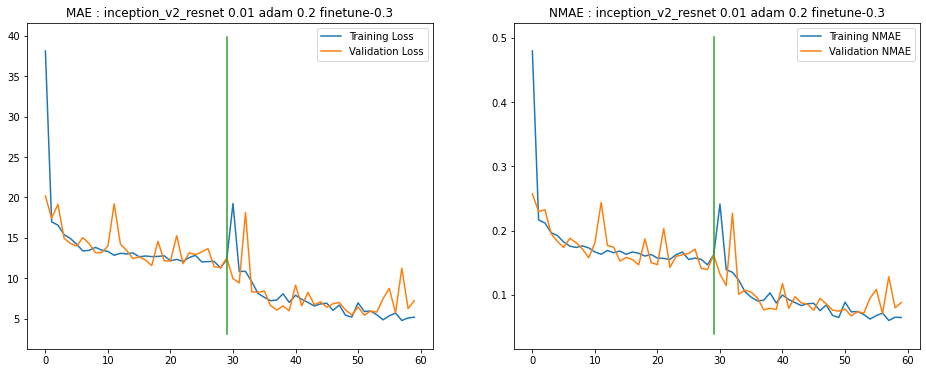

In [54]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

plt.show()

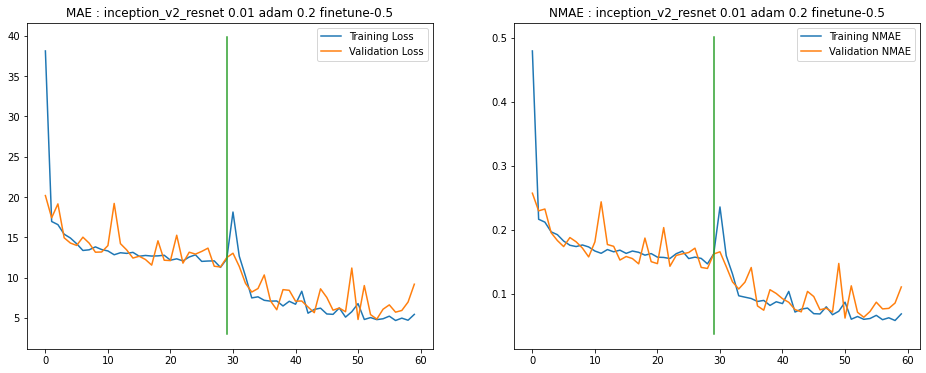

In [48]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

plt.show()

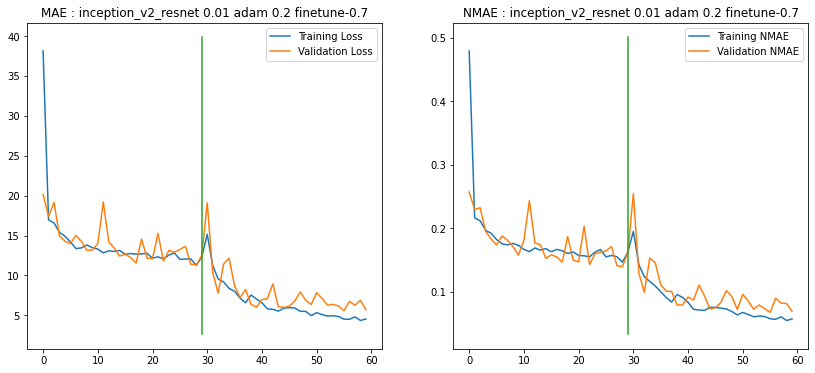

In [20]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('MAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_nmae, label='Training NMAE')
ax2.plot(valid_nmae, label='Validation NMAE')
ax2.legend(loc='upper right')
plt.plot([29,29],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('NMAE : inception_v2_resnet 0.01 adam 0.2 finetune-{}'.format(freeze_rate))

plt.show()

# Prediction

In [62]:
prediction = model.predict(test_generator,
                          steps=len(test_images_path)/PRED_BATCH_SIZE,
                          batch_size = PRED_BATCH_SIZE) 

submission = pd.read_csv('./data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./data/inception v2 resnet 1e-3 adam 0.2 finetune 0.csv', index=False)